In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.decomposition import PCA
import plotly.graph_objects as go

from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import models, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_dataset():

    # Load train data
    train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "ISO-8859-1")

    # Load test data
    test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "ISO-8859-1")

    return train, test


In [115]:
train, test = load_dataset()

# Create full dataset
dataset = pd.concat([train, test])
num_label = dataset['Sentiment'].value_counts()


**Split train set**

In [116]:
validation = pd.DataFrame(columns=train.columns)
split_by_class = train.groupby('Sentiment')

for group, data in split_by_class:
  split = data.sample(frac=0.2, random_state=200)
  validation = validation.append(split, ignore_index=True)
  train = train.drop(split.index.values.tolist())

num_label_train = train['Sentiment'].value_counts()
num_label_validation = validation['Sentiment'].value_counts()
num_label_test = test['Sentiment'].value_counts()


**Plot distribution of the classes in train set and test set**

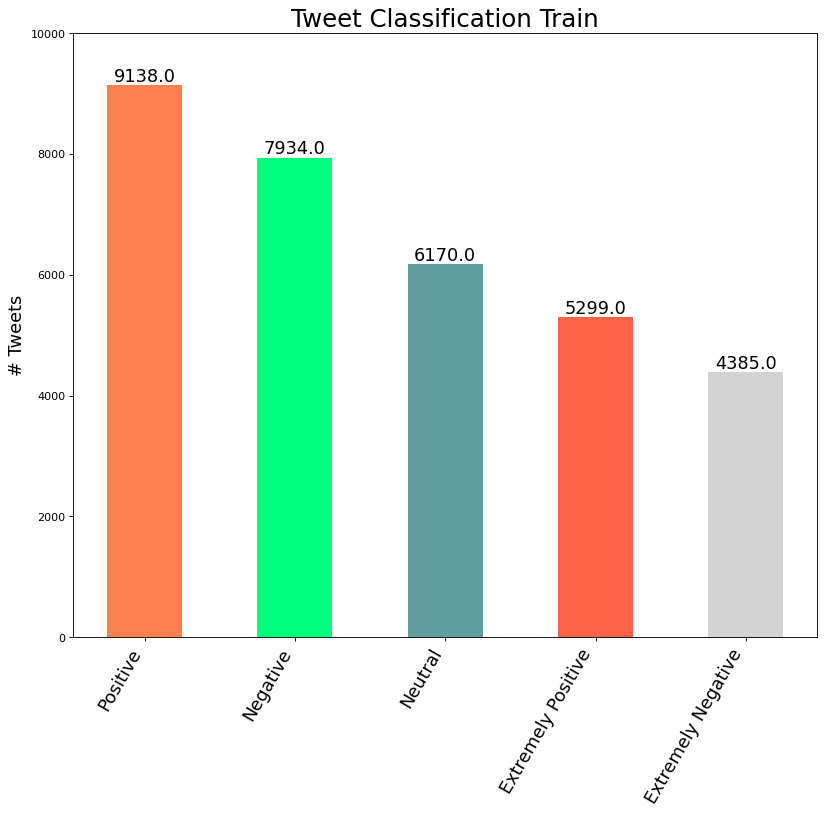

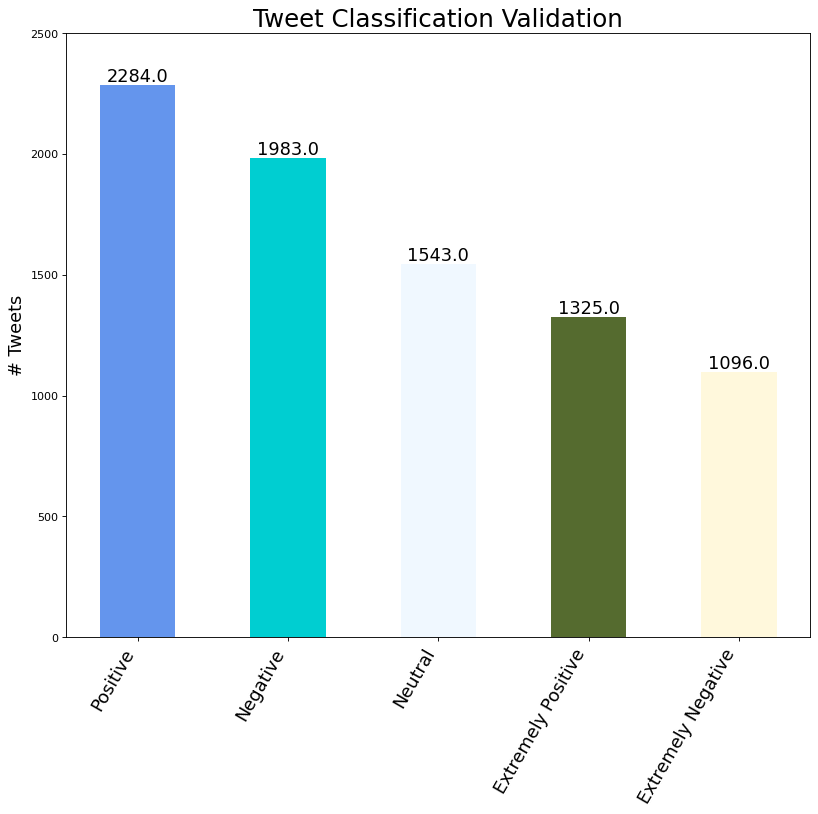

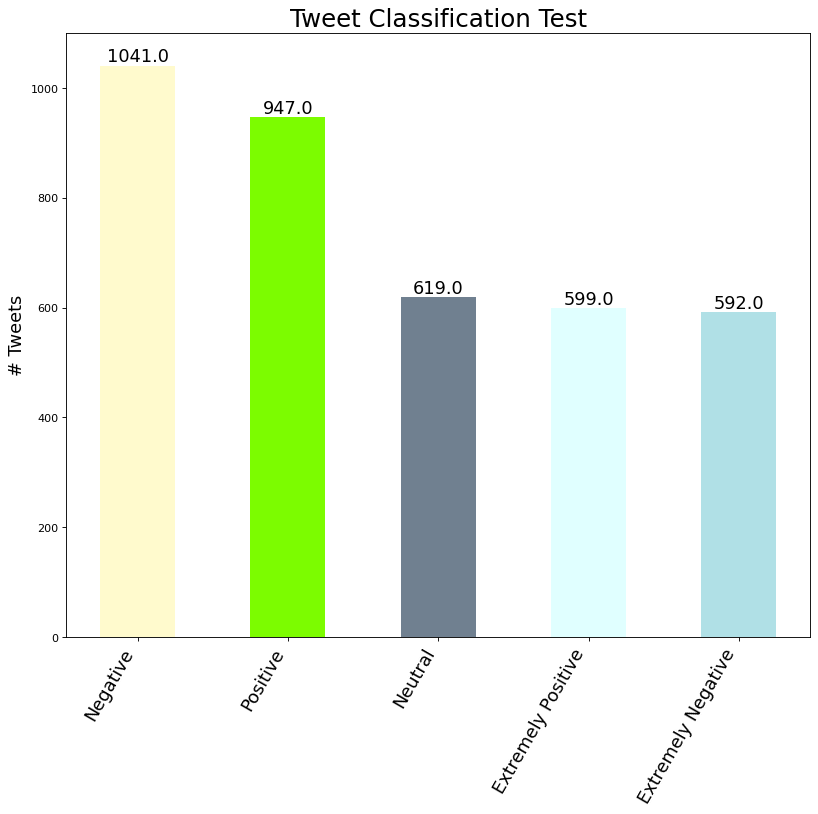

In [117]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 10000)
plot_class_dist(num_label_validation.index, num_label_validation.values, "Tweet Classification Validation", 2500)
plot_class_dist(num_label_test.index, num_label_test.values, "Tweet Classification Test", 1100)


**Plot number of words in the tweets**

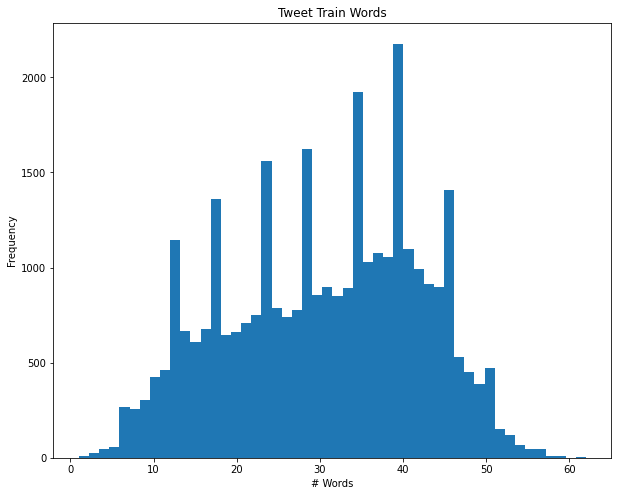

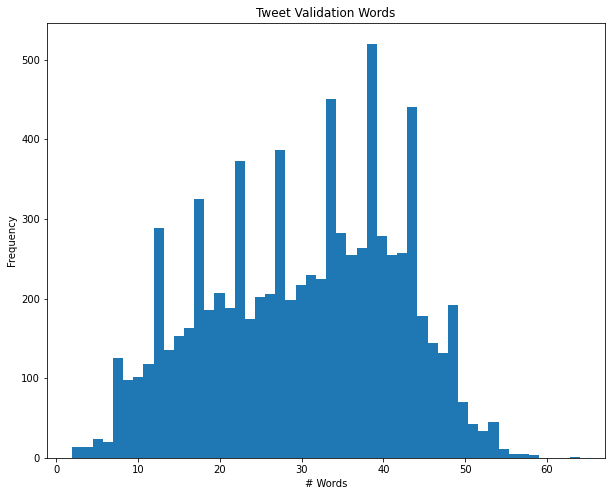

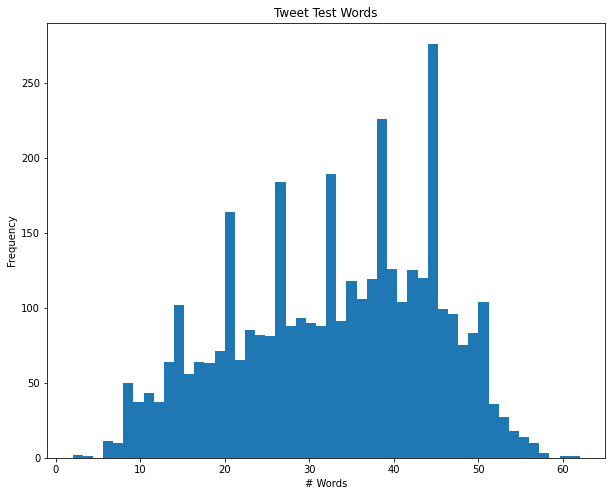

In [ ]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
validation['TotalWords'] = validation['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()

validation['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Validation Words").set_xlabel("# Words")
plt.show()

test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()


**Pre-Processing**

In [119]:
def pre_processing(df):

  # Remove URL from text
  df['NoURL'] = df['OriginalTweet'].str.replace('http\S+|www.\S+', '', case=False)

  # Remove Tag from text
  df['NoTag'] = df['NoURL'].str.replace('@\S+', '', case=False)

  # Remove punctation from text
  df['NoPunct'] = df['NoTag'].str.translate(str.maketrans('', '', string.punctuation))

  return df


def remove_stop_words(df):
  df['NoStopWords'] = df['NoPunct'].apply(lambda x: remove_stopwords(str(x)))
  df['NoStopWords'].replace('', np.nan, inplace=True)
  df.dropna(subset=['NoStopWords'], inplace=True)
  return df

# Full dataset
dataset = pre_processing(dataset)
dataset = remove_stop_words(dataset)
dataset['Words'] = dataset['NoStopWords'].str.split(' ')

# Train set
train = pre_processing(train)
train = remove_stop_words(train)
train['Words'] = train['NoStopWords'].str.split(' ')

# Test set
test = pre_processing(test)
test = remove_stop_words(test)
test['Words'] = test['NoStopWords'].str.split(' ')

# Validation set
validation = pre_processing(validation)
validation = remove_stop_words(validation)
validation['Words'] = validation['NoStopWords'].str.split(' ')


**Create Vocabulary**

In [124]:
# Dataset word2vec model
w2v = Word2Vec(dataset['Words'].tolist())
print(w2v)

# List the vocabulary words
words = list(w2v.wv.vocab)
print(words)
# Show the dictionary of vocab words
w2v.wv.vocab

X = w2v[w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Create a scatter plot of the projection
'''
plt.scatter(result[:, 0], result[:, 1])
words = list(w2v.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()
'''


Word2Vec(vocab=13592, size=100, alpha=0.025)
['advice', 'Talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'schools', 'employer', 'chemist', 'GP', 'set', 'online', 'shopping', 'accounts', 'adequate', 'supplies', 'regular', 'meds', 'order', 'Coronavirus', 'Australia', 'Woolworths', 'elderly', 'disabled', 'dedicated', 'hours', 'amid', 'COVID19', 'outbreak', 'My', 'food', 'stock', 'PLEASE', 'dont', 'panic', 'THERE', 'WILL', 'BE', 'FOOD', 'FOR', 'EVERYONE', 'need', 'Stay', 'calm', 'stay', 'safe', 'coronavirus', 'confinement', 'Me', 'ready', 'supermarket', 'Not', 'Im', 'paranoid', 'The', 'thing', 'It', 'causes', 'shortage', 'StayAtHome', 'As', 'news', 'confirmed', 'case', 'came', 'County', 'week', 'people', 'flocked', 'area', 'stores', 'purchase', 'cleaning', 'hand', 'sanitizer', 'toilet', 'paper', 'goods', 'reports', 'Cashier', 'grocery', 'store', 'sharing', 'insights', 'Covid19', 'To', 'prove', 'class', 'I', 'know', 'talking', 'Was', 'today', 'Did

'\nplt.scatter(result[:, 0], result[:, 1])\nwords = list(w2v.wv.vocab)\nfor i, word in enumerate(words):\n    plt.annotate(word, xy=(result[i, 0], result[i, 1]))\n\nplt.show()\n'

In [125]:
def getEmbedding(list_words, w2v_model):
    word_set = set(w2v_model.wv.index2word)
    X = np.zeros([len(list_words), 100])
    c = 0
    for words in list_words:
        nw=99
        for w in words:
            if w in word_set:
                X[c] = w2v_model[w]
                nw=nw-1
        c=c+1
    return X

**Baseline**

In [128]:
x_train = getEmbedding(train["Words"].tolist(), w2v)
x_test = getEmbedding(test["Words"].tolist(), w2v)
x_val = getEmbedding(validation["Words"].tolist(), w2v)

In [127]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, train["Sentiment"].values).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))

Number of mislabeled points out of a total 3796 points : 3074


In [129]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

KeyboardInterrupt: ignored

In [ ]:
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

Number of mislabeled points out of a total 3796 points : 2830


In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values != y_pred).sum()))
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

Number of mislabeled points out of a total 3796 points : 2847


0.25

**New Network**

In [ ]:
def create_dataset(xs, ys, n_classes=10):
  ys = tf.one_hot(ys, depth=n_classes)
  return tf.data.Dataset.from_tensor_slices((xs, ys)) \
    .map(preprocess) \
    .shuffle(len(ys)) \
    .batch(128)

train_dataset = create_dataset(x_train, y_train, 5)
val_dataset = create_dataset(x_val, y_val, 5)

In [ ]:
model = keras.Sequential([                     
    keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(x_train[], 28)),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=192, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])